<a href="https://colab.research.google.com/github/Ostroverkhov/master-thesis/blob/master/UTKClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchsummary 

from tqdm import tqdm_notebook
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Подготовка датасета

In [0]:
# Класс для получения url и меток изображений
class UTKImageFolder(ImageFolder):
    # В датасете всего 5 классов, но т.к. 5 класс не обладает четкими признаками
    # и не несет смысловой нагрузки, то его игнорируем
    def __init__(self, root, transform=None, target_transform=None, is_valid_file=None):
        super(UTKImageFolder, self).__init__(root,
                                             transform=transform,
                                             target_transform=target_transform,
                                             loader=torchvision.datasets.folder.default_loader,
                                             is_valid_file=is_valid_file)
        
        self.classes = ['white', 'black', 'asian', 'indian']
        self.class_to_idx = {
            'white': 0,
            'black': 1,
            'asian': 2,
            'indian': 3
            }
            
        file_names = list(map(lambda x: x[0], self.samples))
        temp_file_names = []
        labels = []
        for name in file_names:
          image_name = name.split('/')[-1]
          _, _, race = image_name.split("_")[:3]
          if int(race) == 4:
            continue
          temp_file_names.append(name)
          labels.append(int(race))

        self.targets = labels
        self.imgs = list(zip(temp_file_names, labels))
        self.samples = self.imgs

In [0]:
# Создание Dataset из ImageFolder
class UTKImageDataset(Dataset): 
  def init(self, image_folder): self.array = image_folder.imgs

  def __getitem__(self, index):
    return self.array[index]
 
  def __len__(self):
    return len(self.array)

In [4]:
# Подключаемся к google drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def create_data_loaders(root, transform, ratio, batch_size):
  dataset = UTKImageFolder(root=root, transform=transform)

  # разбивка на train и validation
  train_size = int(ratio * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  trainloader = torch.utils.data.DataLoader(
      train_dataset, 
      batch_size=batch_size,
      shuffle=True, 
      num_workers=2)

  testloader = torch.utils.data.DataLoader(
      test_dataset, 
      batch_size=batch_size,
      shuffle=False, 
      num_workers=2)


  classes = dataset.classes

  return (trainloader, testloader, classes)

In [0]:
transform = transforms.Compose([
                                transforms.Resize(300),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

root = "/content/drive/My Drive/UTKDataset"
ratio = 0.8
batch_size = 16

train_loader, test_loader, classes = create_data_loaders(
    root=root, 
    transform=transform, 
    ratio=ratio, 
    batch_size=batch_size)

# Визуализация данных

In [0]:
# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def showBatch(data_loader):
  # get some random training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  print(images.shape)
  # show images
  imshow(torchvision.utils.make_grid(images))
  # print labels
  print(' '.join('%5s' % classes[labels[j]] for j in range(data_loader.batch_size)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 300, 300])


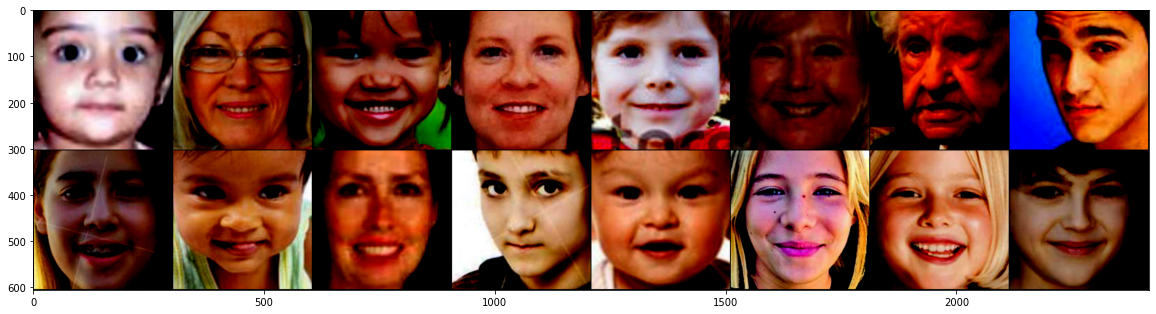

indian white white white white white white white white indian white white white white white white


In [0]:
showBatch(train_loader)

# Конструирование сети


### Создание модулей


In [0]:
# полносвязная сеть
class MyFCNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(120000, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 4)

    def forward(self, x):
        # print(x.shape)
        x = x.view(-1, 120000)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [0]:
# Первая версия сверточной сети
class MyConvNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
# вторая версия сверточной сети
class MyConvNet2(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)

        self.fc1 = nn.Linear(5 * 5 * 1024, 1024)  # !!!
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 5)

    def forward(self, x):
        #(32,32)
        x = F.relu(self.conv1(x))
        #(28,28)
        x = F.relu(self.conv2(x))
        #(26, 26)
        x = F.relu(self.conv3(x))
        #(24, 24)
        x = self.pool(F.relu(self.conv4(x)))
        #(11, 11)
        x = self.pool(F.relu(self.conv5(x)))
        #(5, 5)
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 1024)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

### Инициализация и переход на GPU

In [0]:
# net = MyConvNet1()
# net = MyConvNet2()
net = MyFCNet1()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

MyFCNet1(
  (fc1): Linear(in_features=120000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=5, bias=True)
)

### Вывод параметров сети

In [0]:
torchsummary.summary(net.cuda(), (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]      12,000,100
            Linear-2                  [-1, 120]          12,120
            Linear-3                  [-1, 100]          12,100
            Linear-4                   [-1, 84]           8,484
            Linear-5                    [-1, 5]             425
Total params: 12,033,229
Trainable params: 12,033,229
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 0.00
Params size (MB): 45.90
Estimated Total Size (MB): 46.36
----------------------------------------------------------------


### Accuracy

In [0]:
# загрузка сохраненной модели
PATH = '/content/drive/My Drive/UTKDataset/utkface_net3.pth'
net = MyConvNet2()
net.load_state_dict(torch.load(PATH))
device = torch.device("cpu")
net.to(device)

In [0]:
#  По всем классам
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
# По каждому классу 
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
  

### Train and test functions

In [0]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0
    
    model.train()
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        data, label = batch[0].to(device), batch[1].to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [0]:
def test(model, criterion, dataloader, epoch, device, best_acc, save_path):
    total = 0
    correct = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            
            loss = criterion(output, label)
            
            test_loss += loss
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]
    
    acc = 100.*correct/total
    if acc > best_acc:
        state = {
            'model_state_dict': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        save_parameters(state, save_path, 'best_epoch.pth')
    return test_loss / total, acc

In [0]:
def train_loop(model, optim, criterion, traindataloader, testdataloader, device, epoch_count, save_path, saved):
  train_losses = []
  test_losses = []
  best_acc = 0
  best_epoch = -1
  # tqdm.notebook.tqdm
  for i in tqdm_notebook(range(epoch_count)):
    train_loss, train_acc = train(model, optim, criterion, traindataloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testdataloader, i, device, best_acc, save_path=save_path)
    # scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    # show_loss_graph(train_losses, test_losses, best_epoch)
    if saved:
      state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
      }
      save_parameters(state, save_path, 'all_epoch.pth')
    
  return (train_losses, test_losses, best_acc, best_epoch)

In [0]:
def show_loss_graph(train_losses, test_losses, best_epoch):
  clear_output()
  plt.figure(figsize=(18, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Train, loss')
  plt.plot(np.arange(len(test_losses)), test_losses, label='Test, loss')
  plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
  plt.title(f'Epoch {len(train_losses)}')
  plt.legend(loc='best')


In [0]:
def save_parameters(state, save_path, file_name):
  torch.save(state, save_path + '/' + file_name)

# Обучение полносвязной сети


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyFCNet1()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
save_path=root + "/fc1big"
train_loop(model=model, optim=optimizer, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=20, save_path=save_path, saved=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


ValueError: ignored

### Pretrained

In [0]:
def learning_pretrained_resnet18(type):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = models.resnet18(pretrained=True)
  model.to(device)

  if type == 'SGD':
    save_path=root + "/resnet18pretrainedSGD"
    optimizer = optim.SGD(
      model.parameters(), 
      lr=0.001)

  if type == 'SGDM':
    save_path=root + "/resnet18pretrainedSGDM"
    optimizer = optim.SGD(
      model.parameters(), 
      lr=0.001, 
      momentum=0.9)

  if type == 'Adam':
    save_path=root + "/resnet18pretrainedAdam"
    optimizer = optim.Adam(
      model.parameters(),
      lr=0.001)

  if type == 'RMSprop':
    save_path=root + "/resnet18pretrainedRMSprop"
    optimizer = optim.RMSprop(
      model.parameters(),
      lr=0.001)

  for param in model.parameters():
    param.requires_grad = False

  model.fc = nn.Linear(in_features=512, out_features=4).cuda()

  criterion = nn.CrossEntropyLoss()

  train_losses1, test_losses1, best_acc1, best_epoch1 = train_loop(model=model, optim=optimizer, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=5, save_path=save_path, saved=False)
  
  for param in model.parameters():
    param.requires_grad = True

  train_losses2, test_losses2, best_acc2, best_epoch2 = train_loop(model=model, optim=optimizer, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=10, save_path=save_path, saved=False)

  best_acc = best_acc1
  best_epoch = best_epoch1
  if best_acc2 > best_acc1: 
    best_acc = best_acc2
    best_epoch = best_epoch2

  state = {
    'best_acc':  best_acc,
    'best_epoch':  best_epoch,
    'train_losses': train_losses1 + train_losses2,
    'test_losses': test_losses1 + test_losses2
  }
  save_parameters(state, save_path, 'all_epoch.pth')
 

In [0]:
learning_pretrained_resnet18('SGD')
learning_pretrained_resnet18('SGDM')
learning_pretrained_resnet18('Adam')
learning_pretrained_resnet18('RMSprop')

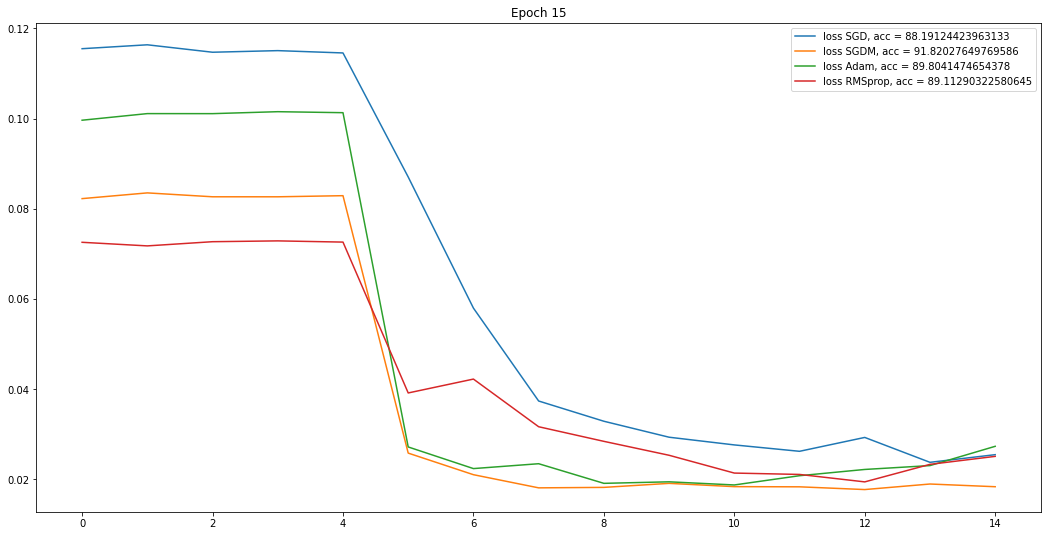

In [0]:
# SGD
all_path_sgd=root + "/resnet18pretrainedSGD/all_epoch.pth"
checkpoint_all_sgd = torch.load(all_path_sgd)

train_losses_sgd = checkpoint_all_sgd['train_losses']
test_losses_sgd = checkpoint_all_sgd['test_losses']
best_acc_sgd = checkpoint_all_sgd['best_acc']
best_epoch_sgd = checkpoint_all_sgd['best_epoch']

# SGDM
all_path_sgdm=root + "/resnet18pretrainedSGDM/all_epoch.pth"
checkpoint_all_sgdm = torch.load(all_path_sgdm)

train_losses_sgdm = checkpoint_all_sgdm['train_losses']
test_losses_sgdm = checkpoint_all_sgdm['test_losses']
best_acc_sgdm = checkpoint_all_sgdm['best_acc']
best_epoch_sgdm = checkpoint_all_sgdm['best_epoch']

# Adam
all_path_adam=root + "/resnet18pretrainedAdam/all_epoch.pth"
checkpoint_all_adam = torch.load(all_path_adam)

train_losses_adam = checkpoint_all_adam['train_losses']
test_losses_adam = checkpoint_all_adam['test_losses']
best_acc_adam = checkpoint_all_adam['best_acc']
best_epoch_adam = checkpoint_all_adam['best_epoch']

# RMSprop
all_path_rmsprop = root + "/resnet18pretrainedRMSprop/all_epoch.pth"
best_path_rmsprop = root + "/resnet18pretrainedRMSprop/best_epoch.pth"
checkpoint_all_rmsprop = torch.load(all_path_rmsprop)
checkpoint_best_rmsprop = torch.load(best_path_rmsprop)

train_losses_rmsprop = checkpoint_all_rmsprop['train_losses']
test_losses_rmsprop = checkpoint_all_rmsprop['test_losses']
best_acc_rmsprop = checkpoint_all_rmsprop['best_acc']
best_epoch_rmsprop = checkpoint_all_rmsprop['best_epoch']


clear_output()
plt.figure(figsize=(18, 9))

plt.plot(np.arange(len(test_losses_sgd)), test_losses_sgd, label=f'loss SGD, acc = {best_acc_sgd}')

plt.plot(np.arange(len(test_losses_sgdm)), test_losses_sgdm, label=f'loss SGDM, acc = {best_acc_sgdm}')

plt.plot(np.arange(len(test_losses_adam)), test_losses_adam, label=f'loss Adam, acc = {best_acc_adam}')

plt.plot(np.arange(len(test_losses_rmsprop)), test_losses_rmsprop, label=f'loss RMSprop, acc = {best_acc_rmsprop}')

plt.title(f'Epoch {len(test_losses_sgd)}')

plt.legend(loc='best')

In [0]:
print(best_epoch_sgd, best_epoch_sgdm, best_epoch_adam, best_epoch_rmsprop)


8 7 5 8


# Пример 1. Полносвязная нс

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyFCNet1()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

train_loop(model=model, optim=optimizer, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=3, model_name='fc1', save_path=root)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


([0.05951594521944057, 0.04034282577954938, 0.034582467488606404],
 [tensor(0.0454, device='cuda:0'),
  tensor(0.0379, device='cuda:0'),
  tensor(0.0346, device='cuda:0')],
 80.64516129032258,
 2)

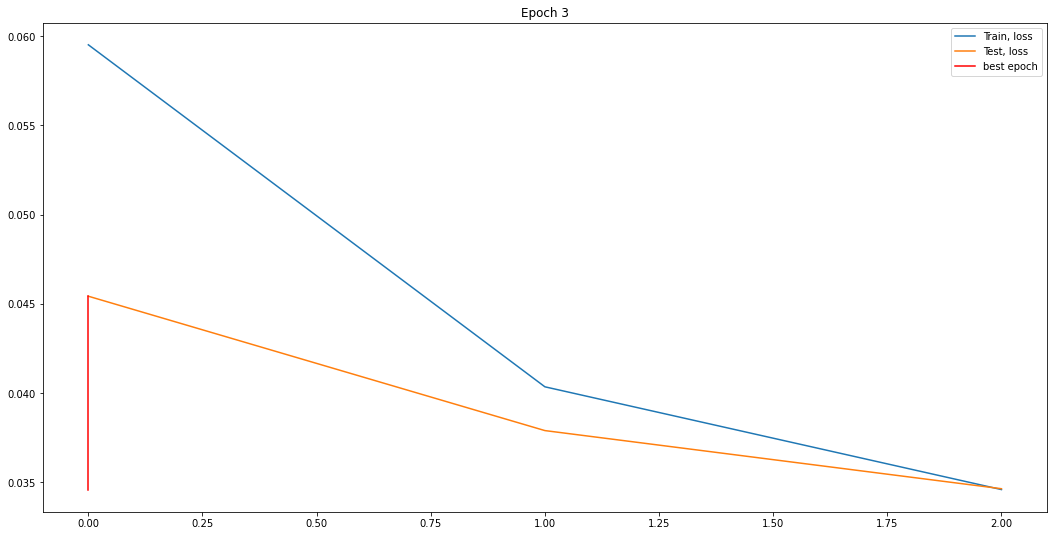

In [0]:
PATH = root + '/' + 'fc1' + '/' + 'all_epoch.pth'
checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

test_losses = checkpoint['test_losses']
train_losses = checkpoint['train_losses']
show_loss_graph(train_losses, test_losses, 0)


In [0]:
alex_net = models.alexnet(pretrained=False)
alex_net.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=4, bias=True)
)

In [0]:
google_net = models.googlenet(pretrained=False)
google_net.fc = nn.Linear(in_features=1024, out_features=4).cuda()

In [0]:
inception_v3 = models.inception_v3(pretrained=False)
inception_v3.fc = nn.Linear(in_features=2048, out_features=4).cuda()

In [0]:
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(in_features=512, out_features=4).cuda()

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


alex_net.to(device)
google_net.to(device)
inception_v3.to(device)
resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(alex_net.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)

optimizer2 = optim.SGD(google_net.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)

optimizer3 = optim.SGD(inception_v3.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)

optimizer4 = optim.SGD(resnet18.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)


save_path1 = root + '/alex_net'
save_path2 = root + '/google_net'
save_path3 = root + '/inception_v3'
save_path4 = root + '/resnet18'

In [0]:
train_loop(model=alex_net, optim=optimizer1, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=10, save_path=save_path1, saved=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


([0.08609308701498573,
  0.07967163142132976,
  0.06918857382209788,
  0.06881744167574921,
  0.0680901656197533,
  0.06822620096304217,
  0.06787387838866521,
  0.0676215489734028,
  0.06720851660805259,
  0.06683893957531017],
 [tensor(0.0860, device='cuda:0'),
  tensor(0.0673, device='cuda:0'),
  tensor(0.0661, device='cuda:0'),
  tensor(0.0655, device='cuda:0'),
  tensor(0.0653, device='cuda:0'),
  tensor(0.0648, device='cuda:0'),
  tensor(0.0649, device='cuda:0'),
  tensor(0.0642, device='cuda:0'),
  tensor(0.0647, device='cuda:0'),
  tensor(0.0638, device='cuda:0')],
 61.117511520737324,
 9)

In [0]:
train_loop(model=google_net, optim=optimizer2, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=10, save_path=save_path2, saved=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


AttributeError: ignored

In [0]:
train_loop(model=inception_v3, optim=optimizer3, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=10, save_path=save_path3, saved=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


AttributeError: ignored

In [0]:
train_loop(model=resnet18, optim=optimizer4, criterion=criterion, traindataloader=train_loader, testdataloader=test_loader, device=device, epoch_count=10, save_path=save_path4, saved=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


([0.0706628683131704,
  0.050831696353750774,
  0.0421142594269177,
  0.035879566421805564,
  0.0311810165158508,
  0.02697340848895525,
  0.02282140873605486,
  0.01811615336123366,
  0.01379405872856329,
  0.012600479092829476],
 [tensor(0.0580, device='cuda:0'),
  tensor(0.0491, device='cuda:0'),
  tensor(0.0409, device='cuda:0'),
  tensor(0.0389, device='cuda:0'),
  tensor(0.0350, device='cuda:0'),
  tensor(0.0344, device='cuda:0'),
  tensor(0.0307, device='cuda:0'),
  tensor(0.0348, device='cuda:0'),
  tensor(0.0404, device='cuda:0'),
  tensor(0.0385, device='cuda:0')],
 81.97004608294931,
 6)